# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Mon Jul 26 18:02:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4 MB 7.1 kB/s 
     |████████████████████████████████| 4.0 MB 40.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.


In [ ]:
from fastai.vision import *
from fastai.vision.interpret import *
from fastai.callbacks.hooks import *
from pathlib import Path
from fastai.utils.mem import *
torch.backends.cudnn.benchmark=True
torch.set_printoptions(profile="full")
from fastai.callbacks import SaveModelCallback

In [ ]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.7.11
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.4.0
nvidia driver : 460.32
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Sat Jun 5 09:50:34 PDT 2021
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/content
/env/python
/usr/lib/python37.zip
/usr/lib/python3.7
/usr/lib/python3.7/lib-dynload
/usr/local/lib/python3.7/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.7/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-r

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/dataset/RTK/
!mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/
!mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
!mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels
!cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/images/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
!cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/pt_labels/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels

## 2. Preparing the data

---



In [ ]:
path = Path('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC')
path.ls()

[PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/models'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/codes.txt'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/validt.txt'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/valid_rf2.txt'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/Cópia de valid.txt'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/valid.txt'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET 

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved', 'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'cracks'], dtype='<U12')

In [ ]:
from PIL import Image
import cv2

In [ ]:
path1 = path/'images/resized'
path2 = path/'labels/resized'
path3 = path/'results_color/resized'

In [ ]:
resize_name = get_image_files(path2)
resize_name.sort()
resize_name1 = get_image_files(path1)
resize_name1.sort()
resize_name2 = get_image_files(path3)
resize_name2.sort()

for i in resize_name:
  mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
  print(np.unique(mask))

[0 2 4]
[0 2 4]
[0 2 4]
[ 0  2  4 11]
[ 0  2  4 11]
[ 0  2 11]
[ 0  2  4  8 11]
[0 2 4]
[ 0  2  4 11]
[ 0  1  2  4 10]
[0 1 2 4]
[0 1 2 4]
[0 2 4]
[0 1 2 4]
[0 2 4]
[0 1 2 4 6]
[0 1 2 4]
[0 1 2 4]
[ 0  2  3  4 10]
[0 2 4 8]
[ 0  2  4 10]
[ 0  1  2  4 10]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[0 1 2 4]
[0 1 2 4]
[0 2 4]
[0 2 4 8]
[ 0  2  3  4 11]
[0 2 4]
[ 0  2  4  8 10]
[ 0  2  4 10]
[0 2 4]
[ 0  2  3  4 11]
[0 2]
[0 2]
[0 2 4]
[0 2 3]
[0 2 4]
[0 2 4]
[0 2]
[0 2]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[0 2 4]
[ 0  2  4 10]
[ 0  2  3  4 10]
[0 1 2 3 4]
[ 0  2  4 11]
[0 2 4]
[0 2 3 4]
[0 2 4]
[0 3]
[0 3]
[0 3]
[0 3]
[0 3]
[0 3]
[0 3]
[ 0  3 12]
[0 3]
[0 2 4]
[ 0  3 11]
[ 0  3 11]
[ 0  3 11]
[0 3]
[ 0  3 10]
[ 0  3 10]
[ 0  3 10]
[0 3 4]
[0 3 4]
[ 0  3  4 10]
[ 0  1  2  4 11]
[ 0  3  4 10]
[ 0  3  4 10]
[0 3 4]
[0 2 4]
[ 0  3  4 10]
[0 3 4]
[0 2 4]
[ 0  3 10]
[0 3]
[0 3]
[0 3]
[0 3]
[ 0  3 10]
[0 2 3 4]
[ 0  3 10]
[ 0  3 10]
[ 0  3 10]
[ 0  3 10]
[ 0  3  4 10]
[ 0  2  3 10]
[0 

##Converter tamanho e mudar nomes - Não rodar caso as pastas já estejam organizadas




In [ ]:
#CONVERTER LABEL
fator = 5
len(resize_name)
u = 0
for i in resize_name:
  #img = Image.open(i)
  mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
  mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
                          mask.shape[0]//fator),
                          interpolation=cv2.INTER_NEAREST)
  mask_resized = (np.array(mask_resized)).astype('uint8')
  print(u,i.name,mask_resized.shape, np.unique(mask_resized))
  cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
  u = u + 1

In [ ]:
#CONVERTER IMAGE
fator = 5
len(resize_name1)
u = 0
for i in resize_name1:
  #img = Image.open(i)
  mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
  mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
                          mask.shape[0]//fator),
                          interpolation=cv2.INTER_NEAREST)
  mask_resized = (np.array(mask_resized)).astype('uint8')
  print(u,i.name,mask_resized.shape, np.unique(mask_resized))
  cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
  u = u + 1

In [ ]:
#CONVERTER RESULT_COLOR
fator = 5
len(resize_name2)
u = 0
for i in resize_name2:
  #img = Image.open(i)
  mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
  mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
                          mask.shape[0]//fator),
                          interpolation=cv2.INTER_NEAREST)
  mask_resized = (np.array(mask_resized)).astype('uint8')
  print(u,i.name,mask_resized.shape, np.unique(mask_resized))
  cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
  u = u + 1

In [ ]:
import os
u

218

In [ ]:
#renomeando LABELS os itens da pasta para continuarem no padrão
for i in range(0, u):
    x = str(732+i)
    os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/'+ str(i) +'.png', 
              r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/000000'+ x +'.png')

In [ ]:
#renomeando IMAGES os itens da pasta para continuarem no padrão
for i in range(0, u):
    x = str(732+i)
    os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/'+ str(i) +'.png', 
              r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/000000'+ x +'.png')

In [ ]:
#renomeando RESULTS_COLOR os itens da pasta para continuarem no padrão
for i in range(0, u):
    x = str(732+i)
    os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/'+ str(i) +'.png', 
              r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/000000'+ x +'.png')

## Continuação dos dados

In [ ]:
path_output_lbl = path/'labels/outputs_clean'
lbl_names = get_image_files(path_output_lbl)
#troquei path_lbl por path2
lbl_names[:3]
len(lbl_names)
lbl_names.sort()

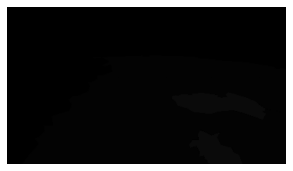

In [ ]:
img_f = lbl_names[130]
img = open_image(img_f)
img.show(figsize=(5,5))

# imagem fnames[55] está com problema de aparecer 13 no tensor (imagem final 787)
# usar fnames.sort()

In [ ]:
get_y_fn = lambda x: path_output_lbl/f'{x.stem}{x.suffix}'

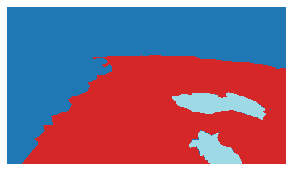

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data


(array([216, 384]),
 tensor([[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
            0,  0,  0,  0,  0,  

## Test

In [ ]:
c = 0
for i in lbl_names:
  img_f = lbl_names[c]
  mask = open_mask(get_y_fn(img_f))
  if mask.data.max() > 12:
    print(f'{c}. max = {mask.data.max()}')
    print(lbl_names[c])
  c = c + 1

In [ ]:
path_output_img = path/'images/outputs_clean'
path_output_col = path/'results_color/outputs_clean'
fnames = get_image_files(path_output_img)
fnames.sort()
fnames[:3]

[PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean/000000732.png'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean/000000733.png'),
 PosixPath('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean/000000734.png')]

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [ ]:
src_size

array([216, 384])

In [ ]:
size = src_size
free = gpu_mem_get_free_no_cache()

if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 0MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, resize_method=ResizeMethod.SQUISH, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

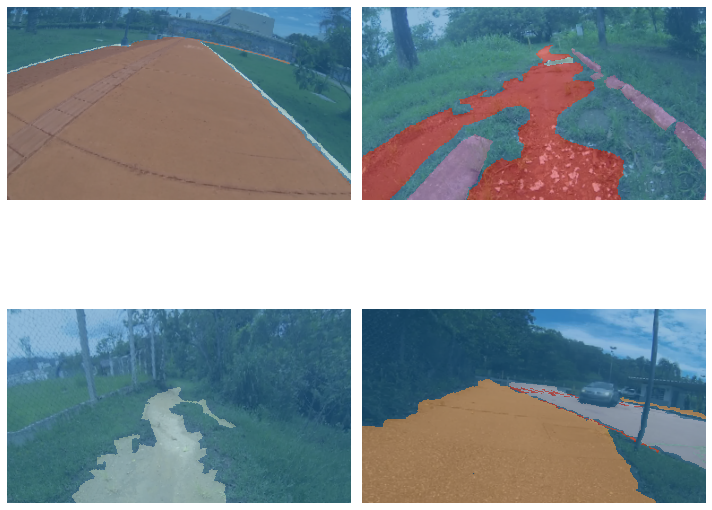

In [ ]:
data.show_batch(2, figsize=(10,10))

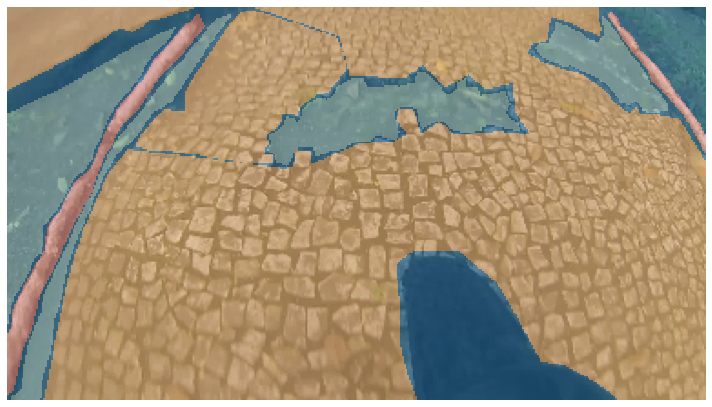

In [ ]:
data.show_batch(1, figsize=(10,7), ds_type=DatasetType.Valid)

### 3.2. First step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'background': 0,
 'catsEye': 6,
 'cracks': 12,
 'manholeCover': 8,
 'patchs': 9,
 'pothole': 11,
 'roadAsphalt': 1,
 'roadMarking': 4,
 'roadPaved': 2,
 'roadUnpaved': 3,
 'speedBump': 5,
 'stormDrain': 7,
 'waterPuddle': 10}

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [ ]:
lr=1e-3


#lr = 3e-3

In [ ]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.9, 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='saved_net')])

"SaveModelCallback(learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel') :: TrackerCallback"
# every:str='improvement'

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 73
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(100, slice(lr), 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net')])

Loaded saved_net_72


In [ ]:
lr

0.001

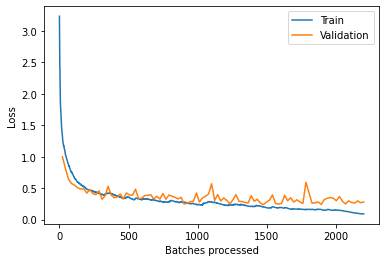

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1_dsufsc1')

In [ ]:
learn.load('stage-1_dsufsc1');

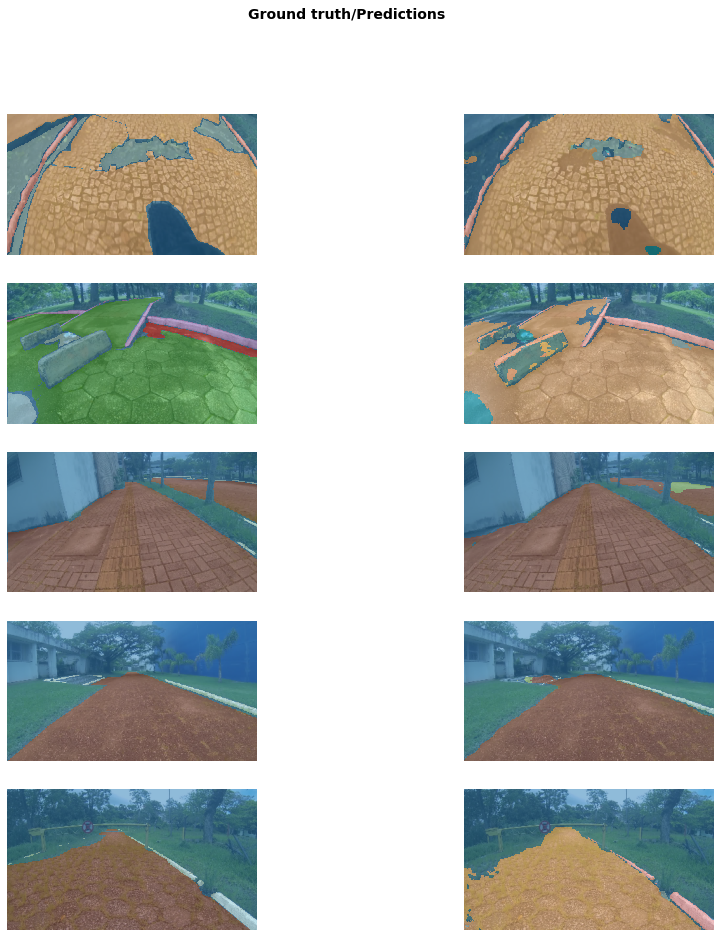

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 3.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((216,384))

(array([6., 4., 1., 0., 1., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]),
 array([0.030761, 0.084966, 0.139172, 0.193377, 0.247582, 0.301788, 0.355993, 0.410198, 0.464404, 0.518609, 0.572814,
        0.62702 , 0.681225, 0.73543 , 0.789636, 0.843841, 0.898046, 0.952252, 1.006457, 1.060663, 1.114868],
       dtype=float32),
 <a list of 20 Patch objects>)

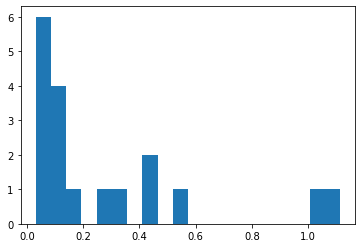

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([ 0,  7,  9, 16,  6])

### 3.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

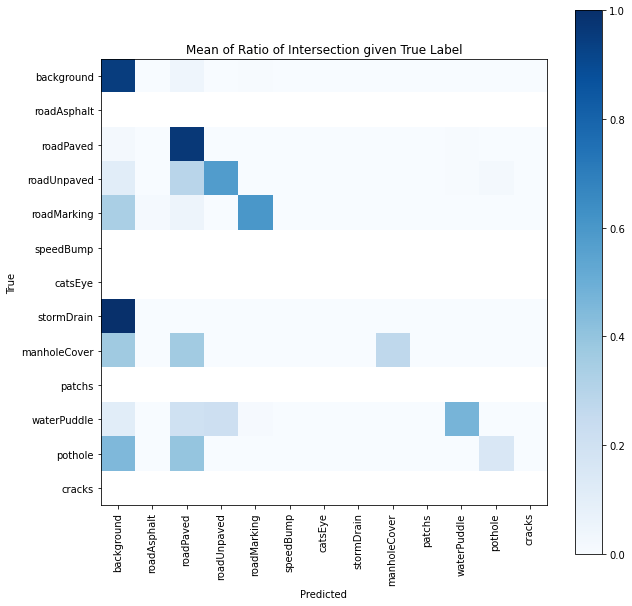

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

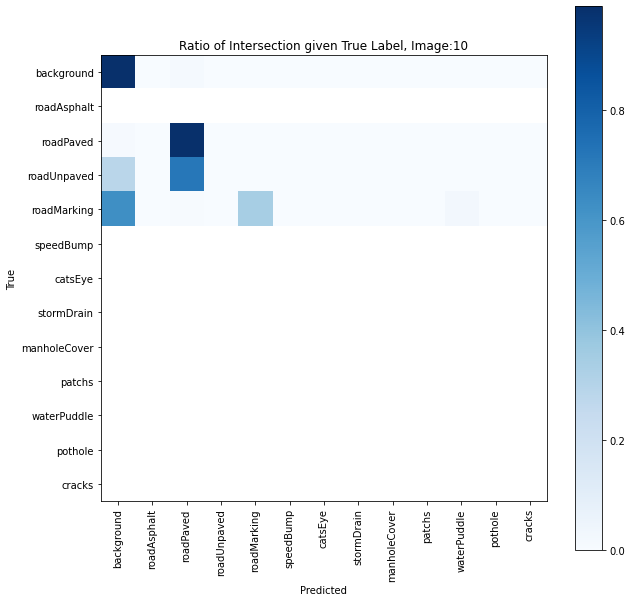

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

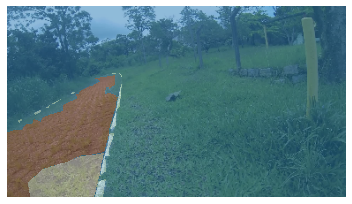

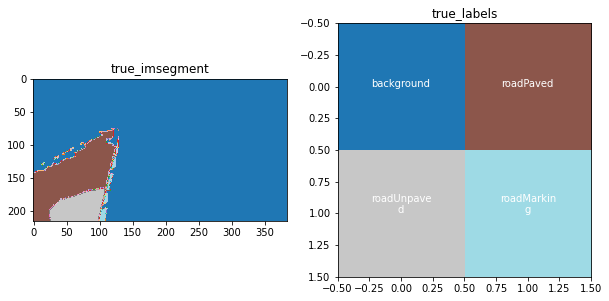

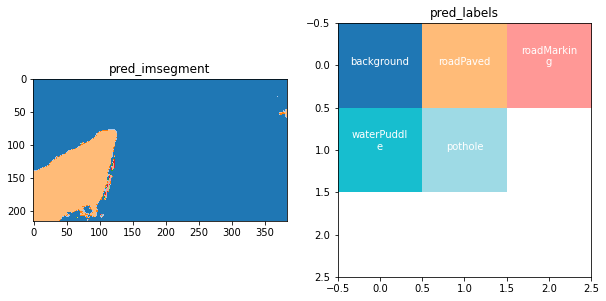

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.5. First model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.9, callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net_continuation')])

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(100, lrs, 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net_continuation')])

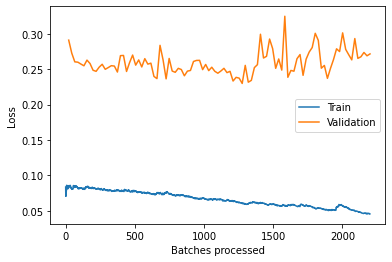

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2_dsufsc1')

In [ ]:
learn.load('stage-2_dsufsc1');

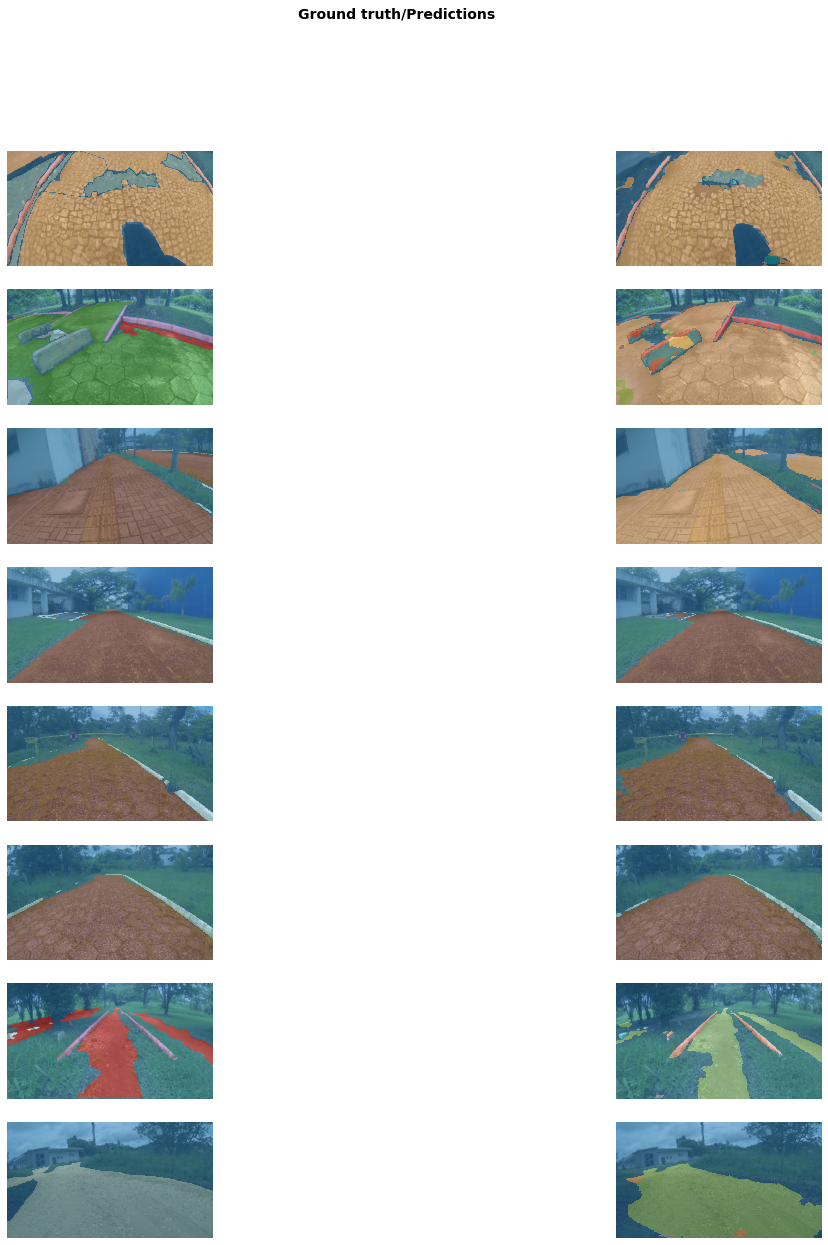

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 3.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

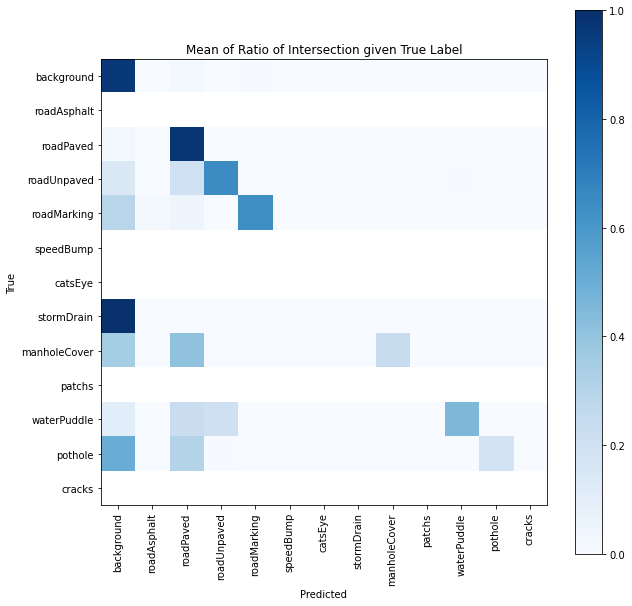

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

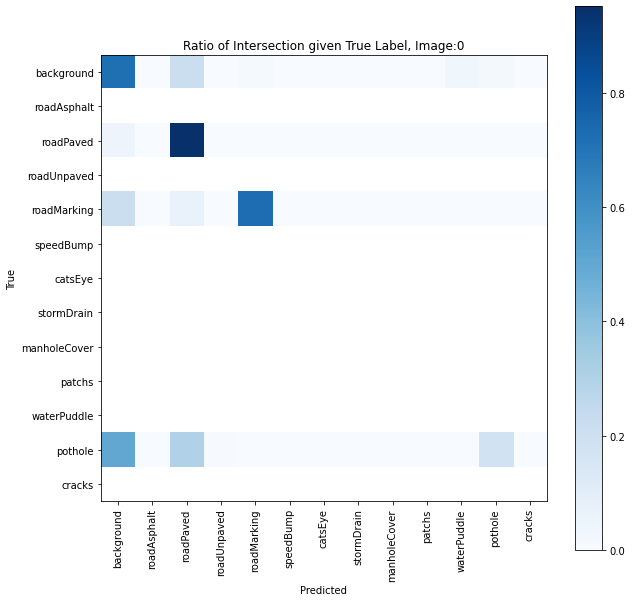

In [ ]:
# single image class performance
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

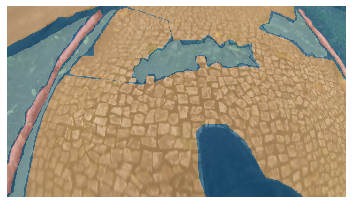

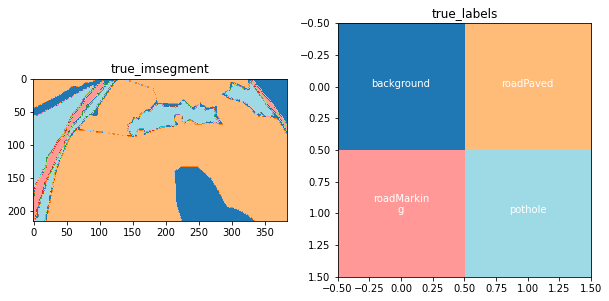

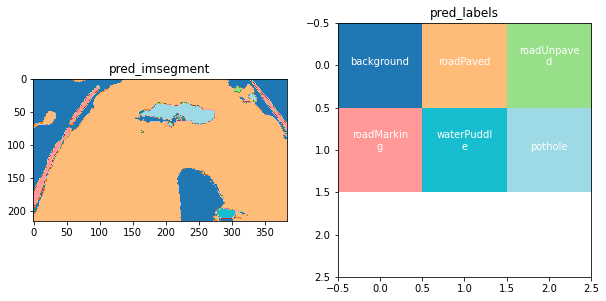

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.7. Interpret

---



In [ ]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (176 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Valid: LabelList (18 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64

### 3.8. Saving

---



In [ ]:
learn.save('stage-2_dsufsc1')

In [ ]:
learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc1.pkl')

In [ ]:
data=None
learn=None
gc.collect()

53986

## 4. Second Step - With weights

---



### 4.1. Second step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11953MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

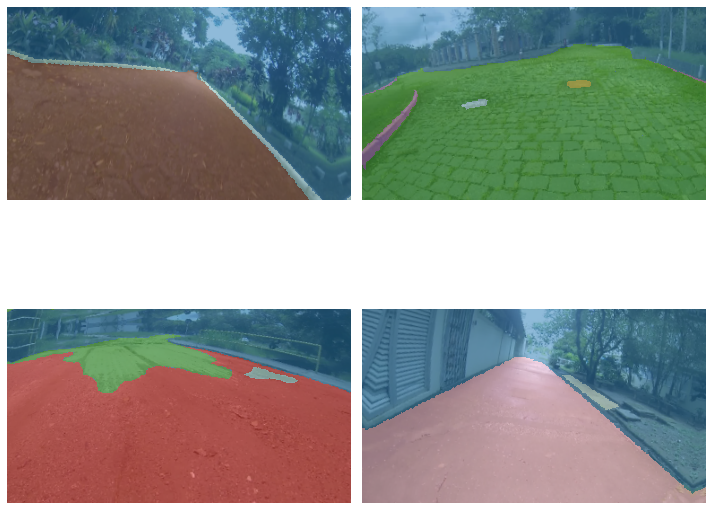

In [ ]:
data.show_batch(2, figsize=(10,10))

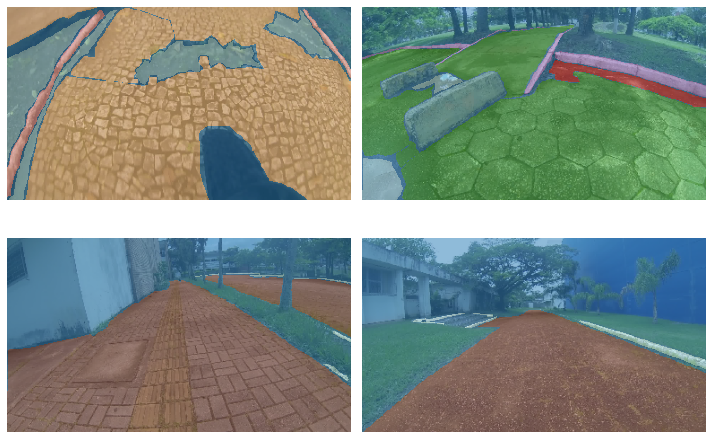

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 4.2. Second step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [ ]:
learn.load('stage-2_dsufsc1')

Learner(data=ImageDataBunch;

Train: LabelList (176 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Valid: LabelList (18 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),

In [ ]:
!/opt/bin/nvidia-smi

Wed May 12 14:10:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   3316MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


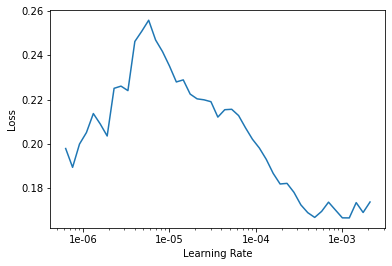

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.9, 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='saved_net2')])

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 8
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(10, slice(lr), 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net2')])

Loaded saved_net2_7


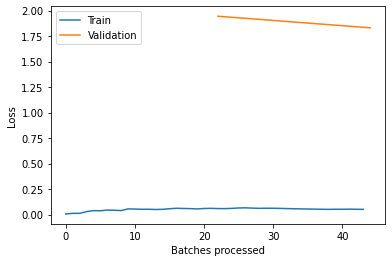

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-weights_dsufsc1')

In [ ]:
learn.load('stage-1-weights_dsufsc1');

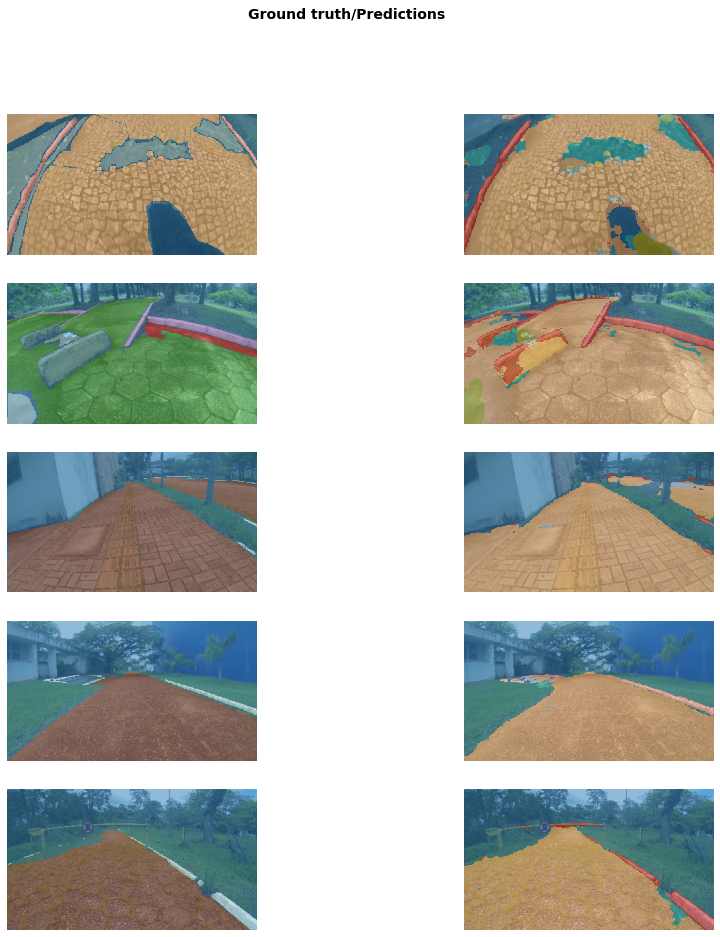

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 4.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((216,384))

(array([13.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.816410e-01, 5.587856e+01, 1.114755e+02, 1.670724e+02, 2.226693e+02, 2.782663e+02, 3.338632e+02, 3.894601e+02,
        4.450570e+02, 5.006539e+02, 5.562509e+02, 6.118478e+02, 6.674447e+02, 7.230416e+02, 7.786385e+02, 8.342355e+02,
        8.898324e+02, 9.454293e+02, 1.001026e+03, 1.056623e+03, 1.112220e+03], dtype=float32),
 <a list of 20 Patch objects>)

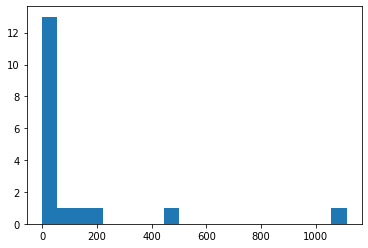

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([ 9,  0, 16,  1, 12])

### 4.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

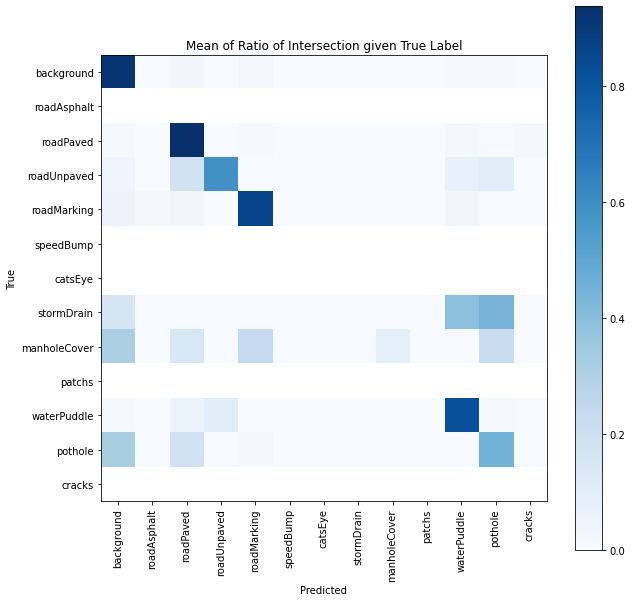

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

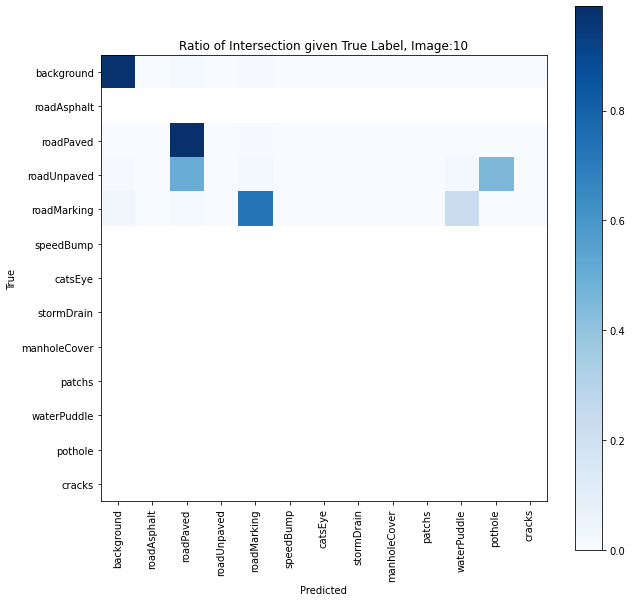

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

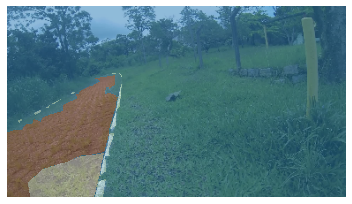

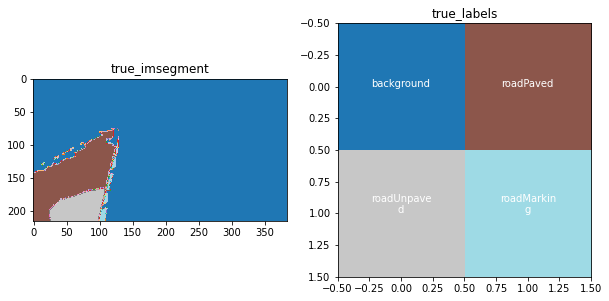

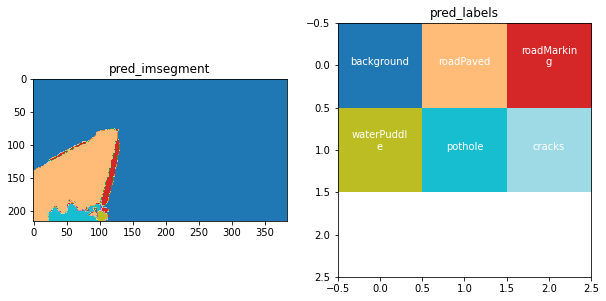

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.5. Second model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.8, callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net2_continuation')])

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(100, lrs, 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net2_continuation')])

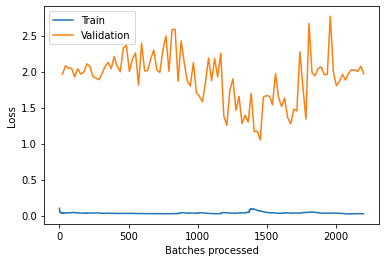

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-weights_dsufsc1')

In [ ]:
learn.load('stage-2-weights_dsufsc1');

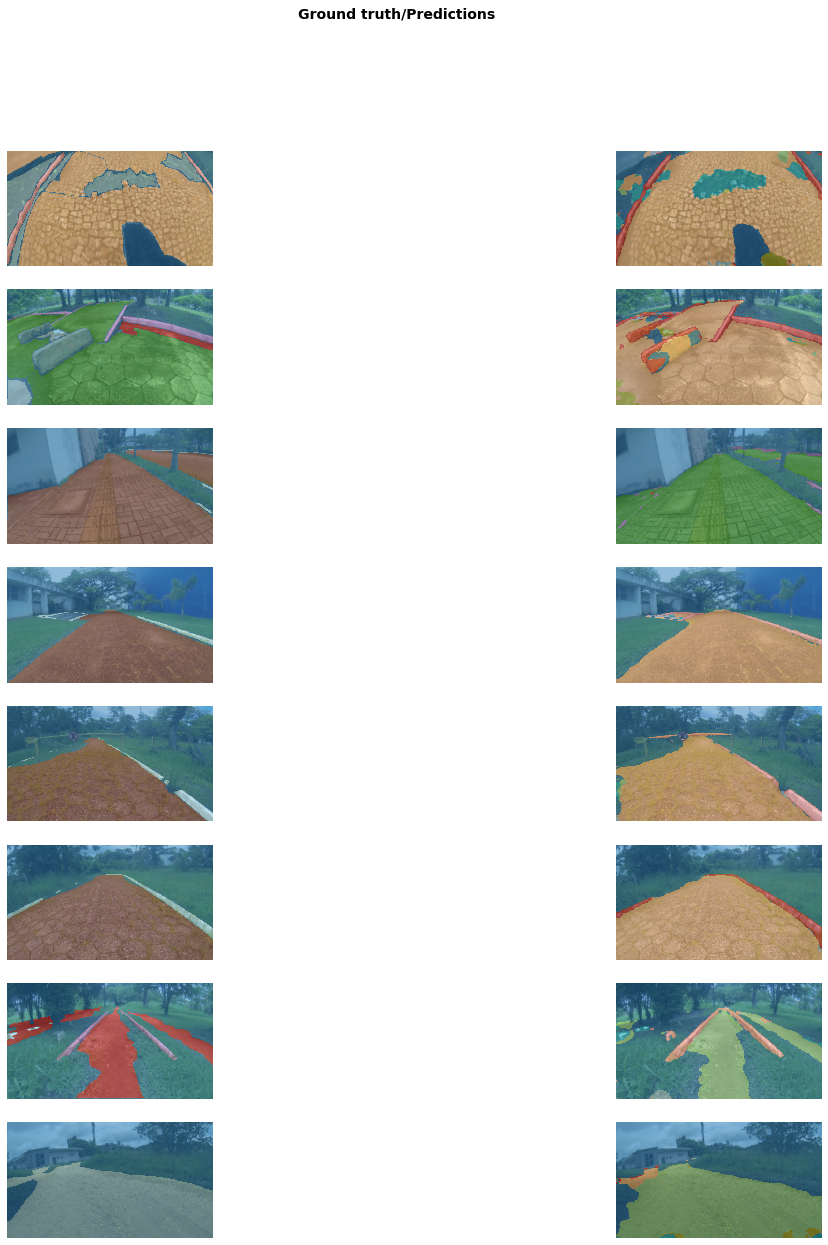

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 4.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

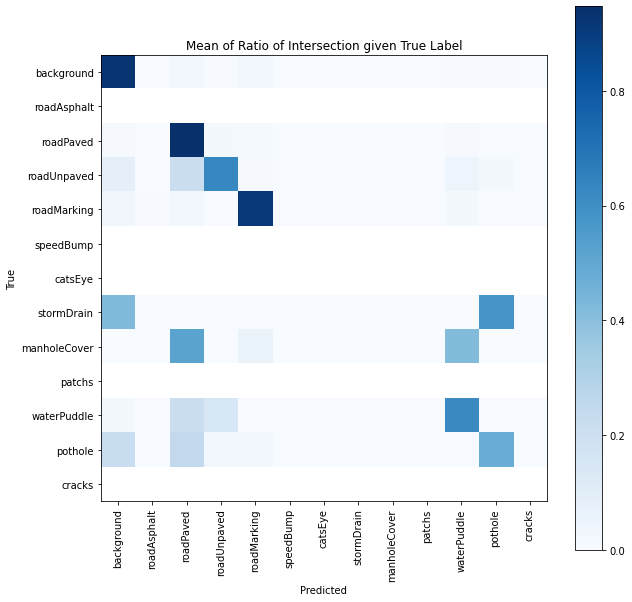

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

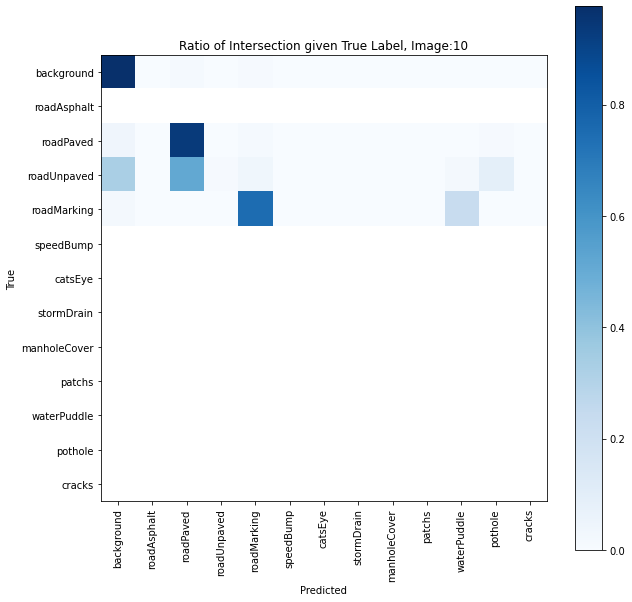

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

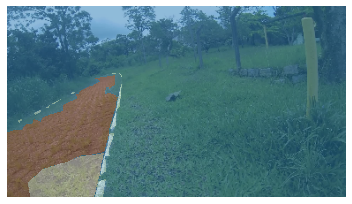

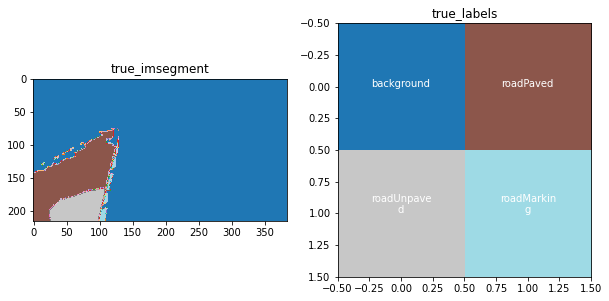

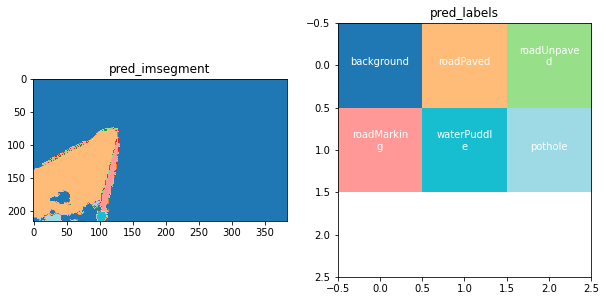

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.7. Interpret

---



In [ ]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (176 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Valid: LabelList (18 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64

### 4.8. Saving

---



In [ ]:
learn.save('stage-2-weights_dsufsc1')
#mudar nomes de arquivos
learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc_v10_100epochs.pkl')

## 5. Using a saved model to Predict

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11405MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34)

In [ ]:
learn.load('stage-2-weights_dsufsc1');

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

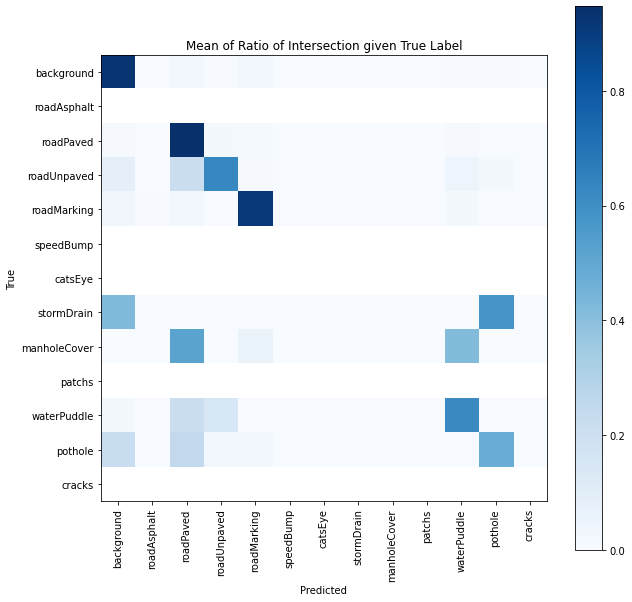

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

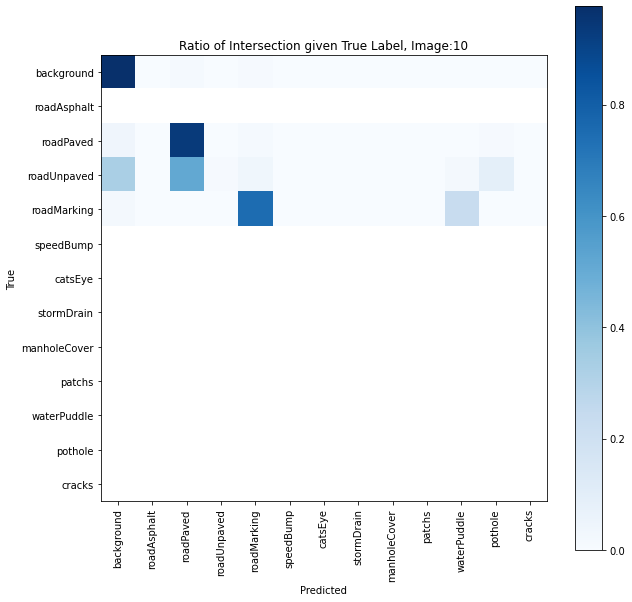

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

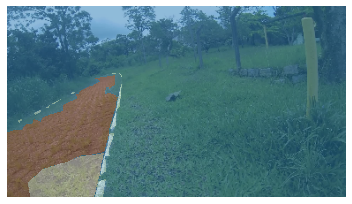

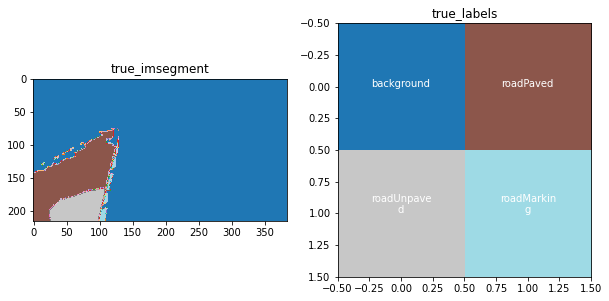

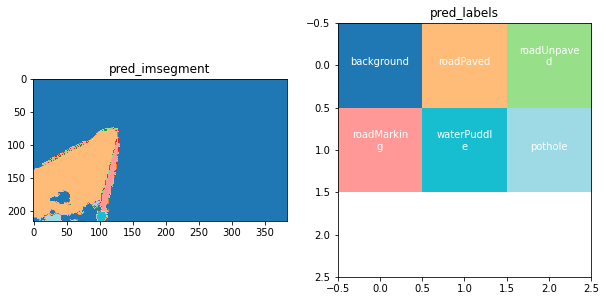

In [ ]:
# show xyz
interp.show_xyz(i)

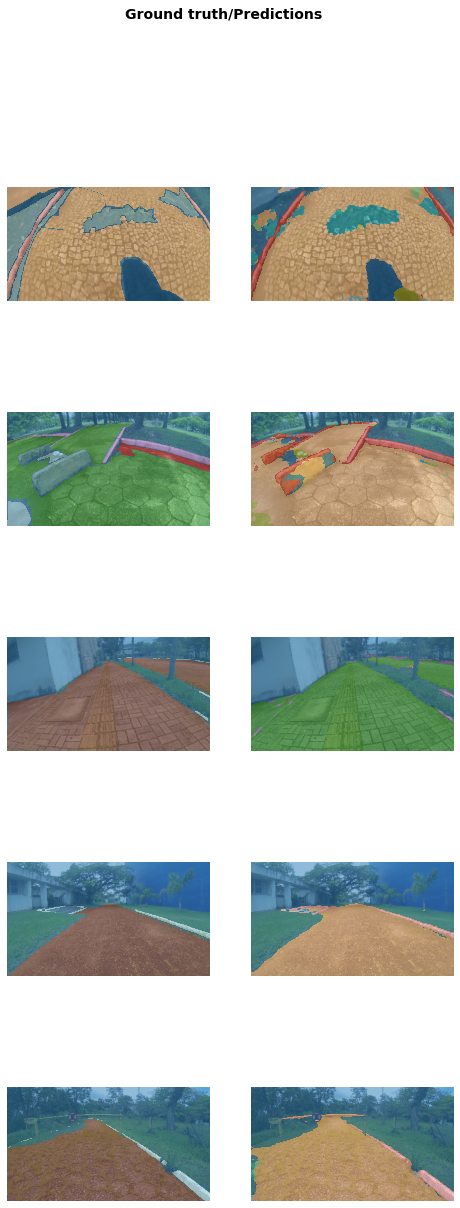

In [ ]:
learn.show_results()

## 6. Saving the Results

---



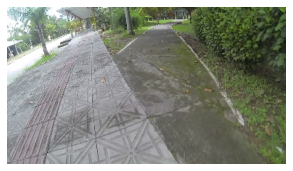

In [ ]:
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
import time
start = time.time()
prediction = learn.predict(img)
print(time.time() - start)

2.2406399250030518


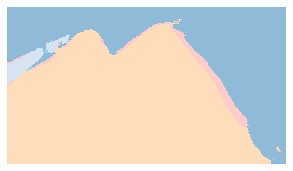

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [ ]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        #sempre checar o esse numero aqui em baixo para ver se está correto com o path!! 
        img_split = img_split[97:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [ ]:
save_preds(fnames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 216
  height = 384
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
Done!
